# Fine-Tuning BERT on GLUE - STSB

From [Archive.org snapshot of dataset homepage](https://web.archive.org/web/20240319092902/http://ixa2.si.ehu.eus/stswiki/index.php/STSbenchmark):

STS Benchmark comprises a selection of the English datasets used in the STS tasks organized in the context of SemEval between 2012 and 2017. The selection of datasets include text from image captions, news headlines and user forums. 

## Configuration

In [1]:
import os

# Where to store the huggingface data. On the provided Jupyterlab instance that should be within the shared group folder.
os.environ['HF_HOME'] = '../groups/192.039-2024W/bert/huggingface/cache'

In [2]:
from pathlib import Path

from transformers import set_seed

# RANDOMNESS SEED
SEED = 42
set_seed(SEED)

# Which dataset to load
DATASET_NAME = "glue"
DATASET_TASK = "stsb"

PRE_TRAINED_CHECKPOINT = "google-bert/bert-base-uncased"

TRAIN_OUTPUT_DIR = (
    Path("../groups/192.039-2024W/bert") / "training" / f"{DATASET_NAME}-{DATASET_TASK}"
)

BATCH_SIZE = 32  # Original Paper claims to use 32 for GLUE tasks
NUM_EPOCHS = 5  # Original Paper claims to use 3 fine-tuning epochs for GLUE tasks

In [3]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  device_count = torch.cuda.device_count()
  device_name = torch.cuda.get_device_name(0)

  print(f"There are {device_count} GPU(s) available.")
  print(f"GPU used: {device_name}")
  ! nvidia-smi -q --display=MEMORY,COMPUTE

else:
  print("No GPU available, using CPU.")
  device = torch.device("cpu")

There are 1 GPU(s) available.
GPU used: NVIDIA GeForce RTX 4060 Ti

==============NVSMI LOG==============

Timestamp                                 : Sat Jan  4 17:57:51 2025
Driver Version                            : 550.135
CUDA Version                              : 12.4

Attached GPUs                             : 1
GPU 00000000:07:00.0
    FB Memory Usage
        Total                             : 16380 MiB
        Reserved                          : 307 MiB
        Used                              : 9135 MiB
        Free                              : 6939 MiB
    BAR1 Memory Usage
        Total                             : 256 MiB
        Used                              : 28 MiB
        Free                              : 228 MiB
    Conf Compute Protected Memory Usage
        Total                             : 0 MiB
        Used                              : 0 MiB
        Free                              : 0 MiB
    Compute Mode                          : Default



## Dataset

In [4]:
# In the GLUE dataset different tasks have different accessor keys
_task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
}

In [5]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset(DATASET_NAME, DATASET_TASK)
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 5749
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1379
    })
})

In [6]:
pd.DataFrame(dataset["train"]).sample(10)

,sentence1,sentence2,label,idx
4034,More than 30 striking miners killed,More than 30 striking miners killed in South A...,3.800,4034
5241,Sony Xperia Z2 and Nokia‚Äôs X series unveiled,Court orders political ban on Italy‚Äôs Berlus...,0.000,5241
2201,He's not wealthy because he's successful.,Why hate people because they are successful?,0.800,2201
4211,Three more US soldiers killed in Afghanistan,NATO Soldier Killed in Afghanistan,1.800,4211
2671,"The songs are on offer for 99 cents each, or $...",The company will offer songs for 99 cents and ...,3.333,2671
3268,"In a not-too-subtle swipe at Dean, he predicte...",They will not elect as president a Democrat wh...,3.500,3268
1161,A small white dog chews on a twig while lying ...,The white dog is laying on the wooden floor un...,1.600,1161
3250,"Still, he noted Miami must decide whether to s...","Still, he noted that Miami must decide whether...",4.600,3250
5333,Puerto Rican arrested for production of child ...,Indian guru arrested on suspicion of rape,0.400,5333
1874,A woman dressed in green is playing with her t...,A tan dog licks a girls hand while laying down.,1.600,1874


For the STSB task each sentence pair is human-annotated with a similarity score from 1 to 5.

In [7]:
unique_lables_in_dataset = pd.DataFrame(dataset["train"])["label"].unique()
num_labels = 1

print(f"{unique_lables_in_dataset=}")
print(f"{num_labels=}")

unique_lables_in_dataset=array([5.        , 3.79999995, 2.5999999 , 4.25      , 0.5       ,
       1.60000002, 2.20000005, 4.19999981, 4.5999999 , 3.8670001 ,
       4.66699982, 1.66700006, 3.75      , 3.20000005, 2.79999995,
       3.        , 4.80000019, 4.        , 4.90899992, 2.4000001 ,
       3.4000001 , 2.75      , 3.5999999 , 1.75      , 1.        ,
       2.375     , 4.4000001 , 4.75      , 1.55599999, 3.93799996,
       3.5       , 1.39999998, 3.83299994, 0.60000002, 2.91700006,
       2.        , 0.80000001, 1.64300001, 2.25      , 4.85699987,
       2.53299999, 0.14300001, 2.5       , 0.        , 0.40000001,
       0.667     , 4.1329999 , 1.20000005, 3.7650001 , 3.94099998,
       0.25      , 3.25      , 0.75      , 1.5       , 0.2       ,
       3.11100006, 1.28600001, 1.79999995, 0.85000002, 3.9230001 ,
       1.25      , 0.833     , 0.333     , 3.33299994, 4.33300018,
       2.66700006, 0.417     , 2.81800008, 3.53299999, 0.64300001,
       1.58299994, 1.778     , 3.6670

## Tokenization

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

BERT has a maximum sequence length of 512. We can check the sequence lengths resulting from tokenizing our dataset to see if our dataset exceeds this restriction of BERT:

In [9]:
first_sentence_key, second_sentence_key = _task_to_keys[DATASET_TASK]

if second_sentence_key == None:  # Simply tokenize sentence

    for split in dataset.keys():
        max_len = 0
        for sentence in dataset[split][first_sentence_key]:
            # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
            input_ids = tokenizer.encode(sentence, add_special_tokens=True)
            
            max_len = max(max_len, len(input_ids))
        

        print(f"Max length in {split=}: {max_len}")

else:  # Append both sentences via [SEP] and tokenize

    for split in dataset.keys():
        max_len = 0
        for sentence1, sentence2 in zip(dataset[split][first_sentence_key], dataset[split][second_sentence_key]):
            # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
            input_ids = tokenizer.encode(sentence1, sentence2,  add_special_tokens=True)
            
            max_len = max(max_len, len(input_ids))
        

        print(f"Max length in {split=}: {max_len}")


Max length in split='train': 125
Max length in split='validation': 87
Max length in split='test': 81


In [10]:
def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/5749 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1379 [00:00<?, ? examples/s]

Here is an example of a tokenized dataset item:

In [11]:
dataset["train"][:1]

{'sentence1': ['A plane is taking off.'],
 'sentence2': ['An air plane is taking off.'],
 'label': [5.0],
 'idx': [0]}

In [12]:
tokenized_dataset["train"][:1]

{'sentence1': ['A plane is taking off.'],
 'sentence2': ['An air plane is taking off.'],
 'label': [5.0],
 'idx': [0],
 'input_ids': [[101,
   1037,
   4946,
   2003,
   2635,
   2125,
   1012,
   102,
   2019,
   2250,
   4946,
   2003,
   2635,
   2125,
   1012,
   102]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]],
 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

Tokenization added the `input_ids` field, which contains the tokenized sentence with a `[CLS]`(101) and two `[SEP]`(102) tokens added. A `token_type_ids` field which indicates first and second portion of the inputs, if necessary. And an `attention_mask` for the given input.

### Dealing with Padding

Huggingface's `transformers` library provides a `DataCollatorWithPadding` class, which allows us to use dynamic padding.  
Dynamic padding will add `[PAD]` tokens to the length of the longest sequence within a batch, instead of padding to the maximum sequence length within the entire dataset.  
This will avoid unnecessary padding and therefore improve execution efficiency.

In [13]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Example: Select a few samples from the training set
samples = tokenized_dataset["train"][:3]
samples = {k: v for k, v in samples.items() if k not in ["idx", first_sentence_key, second_sentence_key]}  # Drop `idx` and `sentence` columns, as DataCollator can't process those.
pd.DataFrame(samples["input_ids"])

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,101,1037,4946,2003,2635,2125,1012,102,2019,2250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101,1037,2158,2003,2652,1037,2312,8928,1012,102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101,1037,2158,2003,9359,14021,5596,2098,8808,2006,...,29022.0,8808.0,2006.0,2019.0,4895.0,3597.0,23461.0,10733.0,1012.0,102.0


In [14]:
# Apply padding using data_collator
batch = data_collator(samples)
pd.DataFrame(batch["input_ids"])


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,101,1037,4946,2003,2635,2125,1012,102,2019,2250,...,0,0,0,0,0,0,0,0,0,0
1,101,1037,2158,2003,2652,1037,2312,8928,1012,102,...,0,0,0,0,0,0,0,0,0,0
2,101,1037,2158,2003,9359,14021,5596,2098,8808,2006,...,29022,8808,2006,2019,4895,3597,23461,10733,1012,102


We can see that `data_collator` will insert `[PAD]` (0) tokens to the maximum length of the passed batch of data items.

## Evaluation

The GLUE dataset specifies one or more evaluation metrics depending on the selected task.

In [15]:
import numpy as np
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)
metric

EvaluationModule(name: "glue", module_type: "metric", features: {'predictions': Value(dtype='float32', id=None), 'references': Value(dtype='float32', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = evaluate.load('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references

Depending on the selected GLUE task we optimize for different evaluation metrics. See BERT paper p.6:

> F1 scores are reported for QQP and MRPC, Spearman correlations are reported for STS-B, and accuracy scores are reported for the other tasks. We exclude entries that use BERT as one of their components.

In [22]:
_task_to_metric = {
    "cola": "matthews_correlation",
    "mnli": "accuracy",
    "mnli-mm": "accuracy",
    "mrpc": "f1",
    "qnli": "accuracy",
    "qqp": "f1",
    "rte": "accuracy",
    "sst2": "accuracy",
    "stsb": "spearmanr",
}

metric_for_best_model = _task_to_metric[DATASET_TASK]

In [23]:
def get_metric_name_for_specific_task():
    """Helper function to derive the evaluation metric name for the specified GLUE task.

    The tasks specified by the GLUE benchmark use different evaluation metrics.
    Unfortunatly there is no easy way to derive there name after loading the corresponding metric function via HuggingFace's `evaluate` library.
    However we can simply do a "trial run" and expect the name key of its output.
    """
    output = metric.compute(
        predictions=[1, 0], references=[1, 1]
    )  # dummy input - we just want to inspect the returned dictionary.
    metric_names = output.keys()
    
    return list(metric_names)


metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['pearson', 'spearmanr']" as an evaluation metric for the task stsb


In [24]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

# Training

For STSB `num_labels = 1`. This will result in `AutoModelForSequenceClassification` actually triggering the regression modeling, and the loss function will be set to `MSELoss()`.  
See `transformers` library implementation [here](https://github.com/huggingface/transformers/blob/7ae6f070044b0171a71f3269613bf02fd9fca6f2/src/transformers/models/bert/modeling_bert.py#L1564-L1575).

In [25]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    torch_dtype="auto",
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=TRAIN_OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    num_train_epochs=NUM_EPOCHS,
    learning_rate=2e-5,  # Original paper uses best out of  5e-5, 4e-5, 3e-5, and 2e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
)

In [27]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if DATASET_TASK != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

In [28]:
from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

In [29]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary = trainer.train()

--- training_arguments.output_dir='../groups/192.039-2024W/bert/training/glue-stsb'
--- training_arguments.metric_for_best_model='spearmanr'


  0%|          | 0/900 [00:00<?, ?it/s]

{'loss': 2.0545, 'grad_norm': 12.394493103027344, 'learning_rate': 1.7777777777777777e-05, 'epoch': 0.56}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.6414876580238342, 'eval_pearson': 0.8523198366165161, 'eval_spearmanr': 0.84718479920071, 'eval_runtime': 1.6579, 'eval_samples_per_second': 904.782, 'eval_steps_per_second': 28.35, 'epoch': 0.56}
{'loss': 0.6736, 'grad_norm': 14.725046157836914, 'learning_rate': 1.555555555555556e-05, 'epoch': 1.11}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.6297786831855774, 'eval_pearson': 0.8723599314689636, 'eval_spearmanr': 0.8700897064463456, 'eval_runtime': 1.6031, 'eval_samples_per_second': 935.678, 'eval_steps_per_second': 29.318, 'epoch': 1.11}
{'loss': 0.5231, 'grad_norm': 9.297086715698242, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.67}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.5273382067680359, 'eval_pearson': 0.8773388862609863, 'eval_spearmanr': 0.8754828863200265, 'eval_runtime': 1.5963, 'eval_samples_per_second': 939.658, 'eval_steps_per_second': 29.443, 'epoch': 1.67}
{'loss': 0.4289, 'grad_norm': 11.710603713989258, 'learning_rate': 1.1111111111111113e-05, 'epoch': 2.22}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.5121705532073975, 'eval_pearson': 0.8814891576766968, 'eval_spearmanr': 0.8775124055124096, 'eval_runtime': 1.612, 'eval_samples_per_second': 930.524, 'eval_steps_per_second': 29.156, 'epoch': 2.22}
{'loss': 0.3531, 'grad_norm': 8.986407279968262, 'learning_rate': 8.888888888888888e-06, 'epoch': 2.78}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.5202115178108215, 'eval_pearson': 0.8821995258331299, 'eval_spearmanr': 0.8789760559873814, 'eval_runtime': 1.5864, 'eval_samples_per_second': 945.514, 'eval_steps_per_second': 29.626, 'epoch': 2.78}
{'loss': 0.2902, 'grad_norm': 6.865576267242432, 'learning_rate': 6.666666666666667e-06, 'epoch': 3.33}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.5698310732841492, 'eval_pearson': 0.8838173747062683, 'eval_spearmanr': 0.8807719042002081, 'eval_runtime': 1.6062, 'eval_samples_per_second': 933.861, 'eval_steps_per_second': 29.261, 'epoch': 3.33}
{'loss': 0.251, 'grad_norm': 8.357426643371582, 'learning_rate': 4.444444444444444e-06, 'epoch': 3.89}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.5156366229057312, 'eval_pearson': 0.8829105496406555, 'eval_spearmanr': 0.8800418076116006, 'eval_runtime': 1.598, 'eval_samples_per_second': 938.691, 'eval_steps_per_second': 29.412, 'epoch': 3.89}
{'loss': 0.2185, 'grad_norm': 7.356443881988525, 'learning_rate': 2.222222222222222e-06, 'epoch': 4.44}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.5483375787734985, 'eval_pearson': 0.8824662566184998, 'eval_spearmanr': 0.8796938251653577, 'eval_runtime': 1.5995, 'eval_samples_per_second': 937.795, 'eval_steps_per_second': 29.384, 'epoch': 4.44}
{'loss': 0.2107, 'grad_norm': 9.082740783691406, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.5260419249534607, 'eval_pearson': 0.8830761909484863, 'eval_spearmanr': 0.8798237523011697, 'eval_runtime': 1.5994, 'eval_samples_per_second': 937.83, 'eval_steps_per_second': 29.385, 'epoch': 5.0}
{'train_runtime': 183.4151, 'train_samples_per_second': 156.721, 'train_steps_per_second': 4.907, 'train_loss': 0.5559741253323025, 'epoch': 5.0}


In [30]:
training_summary

TrainOutput(global_step=900, training_loss=0.5559741253323025, metrics={'train_runtime': 183.4151, 'train_samples_per_second': 156.721, 'train_steps_per_second': 4.907, 'total_flos': 1026875201319492.0, 'train_loss': 0.5559741253323025, 'epoch': 5.0})

We can call `trainer.evaluate()` to check that the `trainer` instance did indeed reload the model checkpoint with the highest evaluation score:

In [ ]:
trainer.evaluate()

  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.5698310732841492,
 'eval_pearson': 0.8838173747062683,
 'eval_spearmanr': 0.8807719042002081,
 'eval_runtime': 1.611,
 'eval_samples_per_second': 931.084,
 'eval_steps_per_second': 29.174,
 'epoch': 5.0}

In [32]:
training_history = pd.DataFrame(trainer.state.log_history)
training_history.groupby("step").first()

,loss,grad_norm,learning_rate,epoch,eval_loss,eval_pearson,eval_spearmanr,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
step,,,,,,,,,,,,,,,
100,2.0545,12.394493,0.000018,0.555556,0.641488,0.852320,0.847185,1.6579,904.782,28.350,NaN,NaN,NaN,NaN,NaN
200,0.6736,14.725046,0.000016,1.111111,0.629779,0.872360,0.870090,1.6031,935.678,29.318,NaN,NaN,NaN,NaN,NaN
300,0.5231,9.297087,0.000013,1.666667,0.527338,0.877339,0.875483,1.5963,939.658,29.443,NaN,NaN,NaN,NaN,NaN
400,0.4289,11.710604,0.000011,2.222222,0.512171,0.881489,0.877512,1.6120,930.524,29.156,NaN,NaN,NaN,NaN,NaN
500,0.3531,8.986407,0.000009,2.777778,0.520212,0.882200,0.878976,1.5864,945.514,29.626,NaN,NaN,NaN,NaN,NaN
600,0.2902,6.865576,0.000007,3.333333,0.569831,0.883817,0.880772,1.6062,933.861,29.261,NaN,NaN,NaN,NaN,NaN
700,0.2510,8.357427,0.000004,3.888889,0.515637,0.882911,0.880042,1.5980,938.691,29.412,NaN,NaN,NaN,NaN,NaN
800,0.2185,7.356444,0.000002,4.444444,0.548338,0.882466,0.879694,1.5995,937.795,29.384,NaN,NaN,NaN,NaN,NaN
900,0.2107,9.082741,0.000000,5.000000,0.526042,0.883076,0.879824,1.5994,937.830,29.385,183.4151,156.721,4.907,1.026875e+15,0.555974


### Loss and Evaluation Metrics over Training Steps

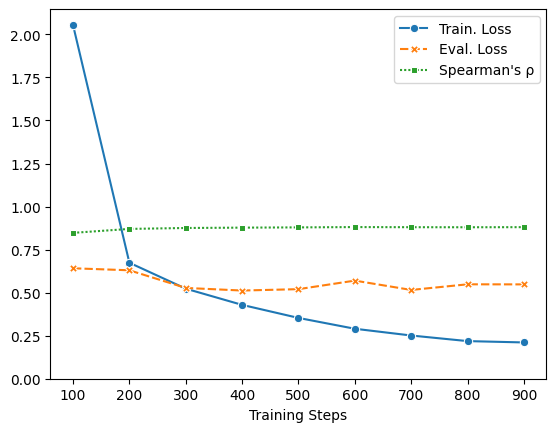

In [37]:
import seaborn as sns

data = training_history[["loss", "eval_loss", "step", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Steps", "Spearman's ρ"]
data = pd.melt(data, ['Training Steps'])

plot = sns.lineplot(data=data, x="Training Steps", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")

from IPython.display import Markdown, display
display(Markdown("### Loss and Evaluation Metrics over Training Steps"))

In [52]:
display(Markdown(f"### Best Model performance:"))
results = pd.DataFrame(
    best_model_evaluation.values(),
    index=best_model_evaluation.keys(),
    columns=["Our Model"],
).drop(
    # Drop runtime measurements
    index=["eval_runtime", "eval_samples_per_second", "eval_steps_per_second", "epoch"]
)
# Achieved scores from original BERT paper:
results["original BERT_BASE"] = ["-", "-", 0.858]
results["original BERT_LARGE"] = ["-", "-", 0.865]
print(f'"Our Model" based on {PRE_TRAINED_CHECKPOINT}, best performance on validation data.')
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"Our Model" based on google-bert/bert-base-uncased, best performance on validation data.
BERT_BASE and BERT_LARGE performance on GLUE testing data as reported in original paper.


,Our Model,original BERT_BASE,original BERT_LARGE
eval_loss,0.569831,-,-
eval_pearson,0.883817,-,-
eval_spearmanr,0.880772,0.858,0.865
